In [1]:
from modules.aesthetic import Aesthetic
from modules.constants import SEED, TRAIN_DIR
from modules.data_loader import DataLoader
from modules.preprocessor import Preprocessor
from modules.vectorizer import Vectorizer
from modules.utils import compute_frequencies

import pandas as pd
import numpy as np

## Exploratory Analysis (IMDB)

In this notebook, the IMDB dataset is analyzed, which contains movie reviews labeled with either a `pos` or `neg` label. The dataset is divided into training data (25k) and test data (25k). Below, various aspects of the dataset are explored to understand if it can be used to train a binary classification model and to gain some insights into various aspects useful for obtaining an optimal model. Specifically, the following analyses are performed:
- Balancing analysis
- Analysis of word frequency (unprocessed)
- Analysis of word frequency (preprocessed)
- Analysis of review length

In [2]:
data_loader = DataLoader(SEED)
preprocessor = Preprocessor(stopwords_language = 'english')
vectorizer = Vectorizer()

In [3]:
X_tain, y_train = data_loader.load_train_data(TRAIN_DIR, validation_split = 0, shuffle = True)

train_df = pd.DataFrame({
	'review': [review.decode() for review in X_tain],
	'label': y_train
})

train_df.head()

,review,label
0,"Silent Night, Deadly Night 5 is the very last ...",0
1,The idea ia a very short film with a lot of in...,1
2,"For me, this movie just seemed to fall on its ...",0
3,Was this based on a comic-book? A video-game? ...,1
4,Caution: May contain spoilers...<br /><br />I'...,1


#### Dataset balancing analysis

In [4]:
train_df_positive = train_df[train_df['label'] == 1]
train_df_negative = train_df[train_df['label'] == 0]

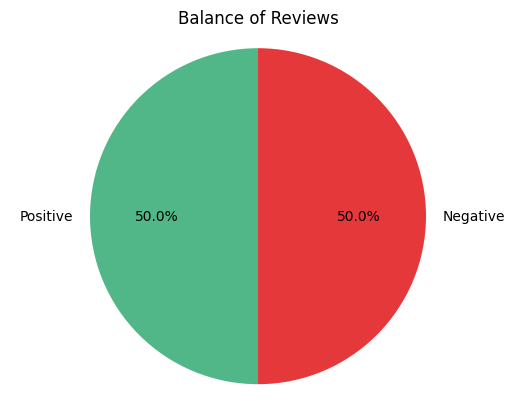

In [5]:
Aesthetic.plot_balance_of_reviews(len(train_df_positive), len(train_df_negative))

The dataset, as can be observed, is balanced across categories. This allows the use of metrics such as accuracy, which work well in the presence of balanced datasets.

#### Analisi useless words

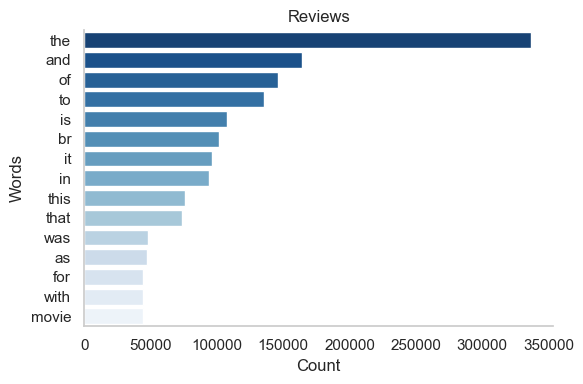

In [6]:
vectorize, train_features = vectorizer.vectorize_data(
	train_df['review'],
	output_mode = 'count',
	preprocessor = None,
	ngram_range = (1, 1),
	max_features = 15
)
word_frequencies = compute_frequencies(vectorize, train_features)
Aesthetic.plot_single_most_important_word(word_frequencies)

As can be seen, the reviews contain many words that do not provide information regarding a possible classification of the reviews. Most of the words in the list are stop words, which are usually eliminated through preprocessing techniques. It is not guaranteed that removing these words will lead to better results. Among the words in the graph, the word composed of the letters `br` is identified, which corresponds to the HTML tag `<br>`. Even in this case, this "word" does not provide any additional meaning. Therefore, to perform a more in-depth analysis of word frequency, a preprocessing function `(Preprocessor.perform_strong_preprocessing)` that removes unnecessary words is used.

#### N-Grams Analysis

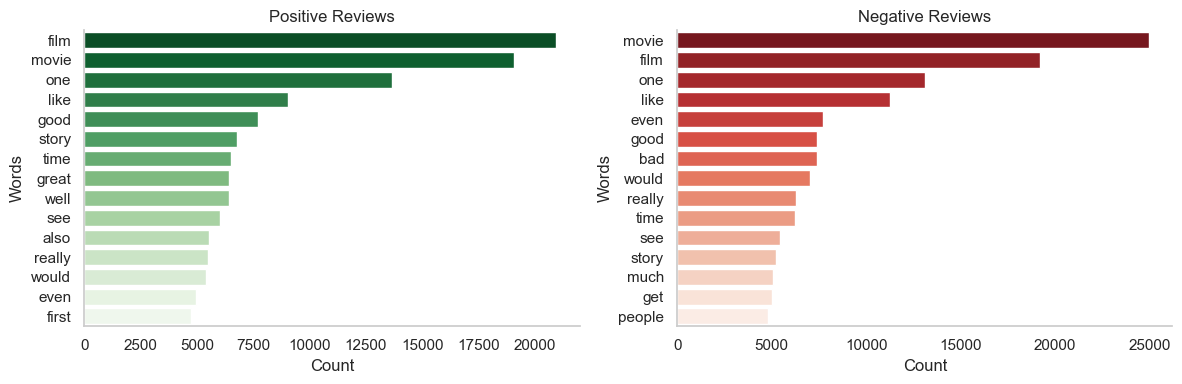

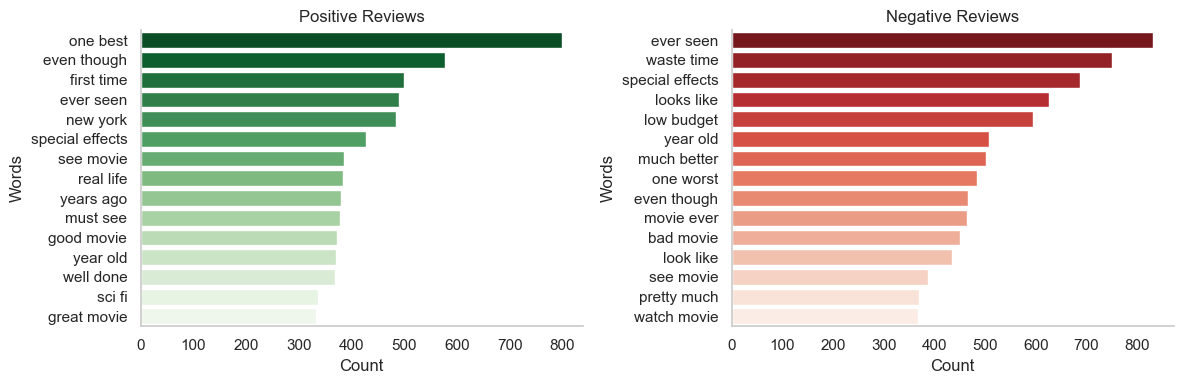

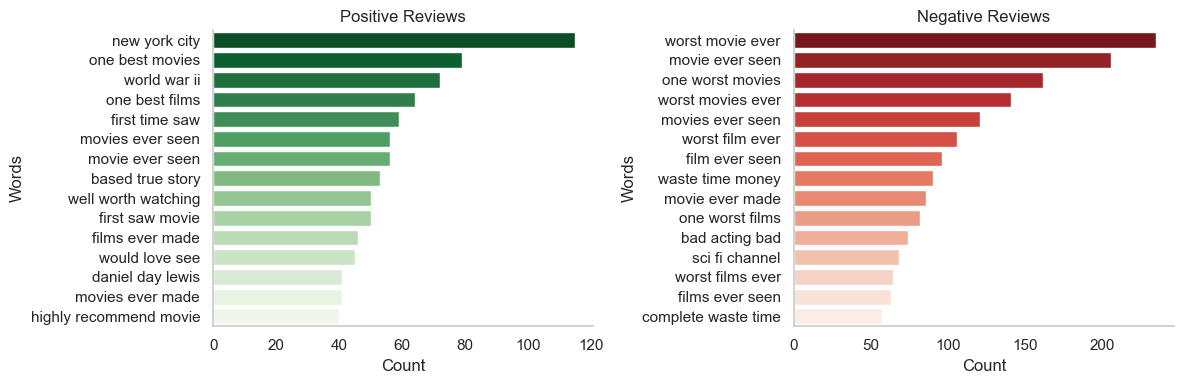

In [7]:
ngrams_list = [(1, 1), (2, 2), (3, 3)]

for ngrams in ngrams_list:

	vectorize_positive, train_features_positive = vectorizer.vectorize_data(
		train_df_positive['review'],
		output_mode = 'count',
		preprocessor = preprocessor.perform_strong_preprocessing,
		ngram_range = ngrams,
		max_features = 15
	)

	vectorize_negative, train_features_negative = vectorizer.vectorize_data(
		train_df_negative['review'],
		output_mode = 'count',
		preprocessor = preprocessor.perform_strong_preprocessing,
		ngram_range = ngrams,
		max_features = 15
	)

	word_frequencies_positive = compute_frequencies(vectorize_positive, train_features_positive)
	word_frequencies_negative = compute_frequencies(vectorize_negative, train_features_negative)
	Aesthetic.plot_most_important_words(word_frequencies_positive, word_frequencies_negative)

As can be seen from the graphs above, using n-grams greater than 1 could be a correct choice. In fact, as shown in the first graph, individual words are almost all common between positive and negative reviews, making it difficult to create a clear distinction. In contrast, it can be observed that the use of 2-grams and 3-grams highlights word frequencies that differ between positive and negative reviews (`pos`: <u>one best</u>, `neg`: <u>waste time</u>). This analysis can be important for obtaining a model that is able to correctly categorize new reviews.

### Review Length
An analysis of the length of the reviews is now reported. This can allow us to understand if it is possible to identify an <u>upper bound</u> that can be used to reduce the length of the reviews and have a fixed size. For example, in the context of neural networks, it is necessary to use vectors of uniform length, or use padding to fill the necessary spaces to obtain vectors of uniform length. Through the following analysis, we can understand if there is a value with which we can truncate the reviews while maintaining a high percentage of information.

Approx interval 299.88868391556286 that covers 0.94544 of the data


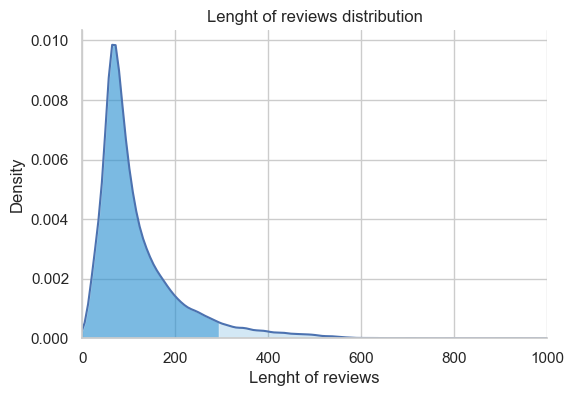

In [10]:
vectorize, train_features = vectorizer.vectorize_data(
	train_df['review'],
	output_mode = 'count',
	max_features = None,
	ngram_range = (1, 1),
	preprocessor = preprocessor.perform_strong_preprocessing,
)

lengths = train_features.sum(axis = 1)
interval_95 = np.mean(lengths) + 2 * np.std(lengths)
data_covarage = np.sum(np.array(lengths) < interval_95) / len(lengths)
print(f'Approx interval {interval_95} that covers {data_covarage} of the data')

Aesthetic.plot_words_distribution(lengths, interval_95)

Approx interval 557.1540336322524 that covers 0.94544 of the data


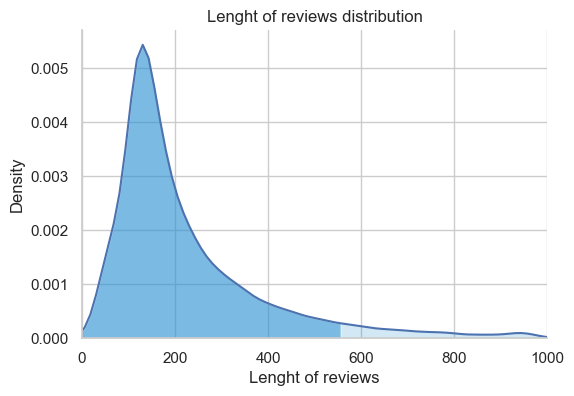

In [11]:
vectorize, train_features = vectorizer.vectorize_data(
	train_df['review'],
	output_mode = 'count',
	max_features = None,
	ngram_range = (1, 1),
	preprocessor = preprocessor.perform_soft_preprocessing,
)

lengths = train_features.sum(axis = 1)
interval_95 = np.mean(lengths) + 2 * np.std(lengths)
data_covarage = np.sum(np.array(lengths) < interval_95) / len(lengths)
print(f'Approx interval {interval_95} that covers {data_covarage} of the data')

Aesthetic.plot_words_distribution(lengths, interval_95)

As we can see from the obtained graphs, we can determine a truncation value for the review lengths while still retaining approximately `95%` of the information. Specifically, two scenarios were analyzed based on the type of preprocessing:
- **Strong Preprocessing**: removal of HTML tags, punctuation, and stop words (`300`)
- **Soft Preprocessing**: removal of HTML tags and punctuation (`557`)

This concludes the exploratory analysis of the IMDB dataset. In the `ml` and `deep` notebooks, techniques for training the model can be explored further.